In [34]:
import argparse

import torch
import torch.nn as nn
import torch.nn.functional as F

import dgl.nn as dglnn
from dgl import AddSelfLoop
from dgl.data import CoraGraphDataset
import torch
import torch.nn as nn
import torch.nn.functional as F

In [35]:
import os
os.environ['DGLBACKEND'] = 'pytorch'
import torch as th
import torch.nn as nn
import torch.nn.functional as F

import dgl
import dgl.function as fn
from dgl import DGLGraph


In [36]:
class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)

    def forward(self, g, feature):
        # Creating a local scope so that all the stored ndata and edata
        # (such as the `'h'` ndata below) are automatically popped out
        # when the scope exits.
        with g.local_scope():
            g.ndata["h"] = feature
            g.update_all(gcn_msg, gcn_reduce)
            h = g.ndata["h"]
            return self.linear(h)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = GCNLayer(8710, 16)
        self.layer2 = GCNLayer(16, 7)

    def forward(self, g, features):
        x = F.relu(self.layer1(g, features))
        x = self.layer2(g, x)
        return x
    

def evaluate(model, g, features, labels, mask):
    model.eval()
    with th.no_grad():
        logits = model(g, features)
        logits = logits[mask]
        labels = labels[mask]
        _, indices = th.max(logits, dim=1)
        correct = th.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)
    
gcn_msg = fn.copy_u(u="h", out="m")
gcn_reduce = fn.sum(msg="m", out="h")

In [37]:
from GOOD.data.good_datasets.good_cora import GOODCora
import torch
import dgl 


def create_data():
    cora_datasets, cora_meta_info = GOODCora.load("good_data/", domain='word', shift='covariate', generate=False)
    dataset = cora_datasets.data

    g = dgl.graph((dataset.edge_index[0], dataset.edge_index[1]))
    g.ndata['feats'] = dataset.x
    g.ndata['labels'] = dataset.y
    g.ndata['train_mask'] = dataset.train_mask
    g.ndata['val_mask'] = dataset.val_mask
    g.ndata['test_mask'] = dataset.test_mask
    g.ndata['id_val_mask'] = dataset.id_val_mask
    g.ndata['id_test_mask'] = dataset.id_test_mask

    labels_to_keep = [57, 33, 27, 7, 53]
    labels_not_to_keep = list(set(range(70)) - set(labels_to_keep))
    for label in labels_not_to_keep:
        label_idx = g.ndata['labels'] == label
        idxs = [i for i, x in enumerate(label_idx) if x]

        g = dgl.remove_nodes(g, idxs)

    label_map = {
        57: 0,
        33: 1,
        27: 2,
        7: 3,
        53: 4
    }

    for i in range(g.num_nodes()):
        g.ndata['labels'][i] = torch.tensor(label_map[int(g.ndata['labels'][i])])

    import pandas as pd

    feats = g.ndata['feats']
    labels = g.ndata['labels']
    data = pd.DataFrame({'feats': torch.tensor(range(feats.shape[0])), 'labels': labels})
    
    return g, data, feats, labels


In [38]:
g, data, feats, labels = create_data()
g.add_edges(g.nodes(), g.nodes())
features = g.ndata["feats"]
labels = g.ndata["labels"]
train_mask = g.ndata["train_mask"]
test_mask = g.ndata["test_mask"]
val_mask = g.ndata["val_mask"]
id_val_mask = g.ndata['id_val_mask']
id_test_mask = g.ndata['id_test_mask'] 


In [39]:
print(sum(train_mask), sum(test_mask), sum(val_mask), sum(id_val_mask), sum(id_test_mask))

tensor(1786) tensor(587) tensor(684) tensor(407) tensor(415)


In [40]:

import random
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [69]:
# dataset = CoraGraphDataset()
# g = dataset[0]
# features = g.ndata["feat"]
# labels = g.ndata["label"]
# train_mask = g.ndata["train_mask"]
# test_mask = g.ndata["test_mask"]
# val_mask = g.ndata["val_mask"]

import time

import numpy as np


import time

import numpy as np

dur = []
seeds = [30,40]
epochs = 50
test_acc_arr = np.zeros((len(seeds), epochs))
id_test_acc_arr = np.zeros((len(seeds), epochs))
train_loss = np.zeros((len(seeds), epochs))
id_val_acc = np.zeros((len(seeds), epochs))
val_acc = np.zeros((len(seeds), epochs))

nets = []




for i_s, seed in enumerate(seeds):
    set_seed(seed)    
    net = Net()
    # Add edges between each node and itself to preserve old node representations
    g, data, feats, labels = create_data()
    g.add_edges(g.nodes(), g.nodes())
    features = g.ndata["feats"]
    labels = g.ndata["labels"]
    train_mask = g.ndata["train_mask"]
    test_mask = g.ndata["test_mask"]
    val_mask = g.ndata["val_mask"]
    id_val_mask = g.ndata['id_val_mask']
    id_test_mask = g.ndata['id_test_mask'] 

    optimizer = th.optim.Adam(net.parameters(), lr=1e-2)


    E = torch.zeros(train_mask.shape[0])
    k = 250
    
    for epoch in range(50):
        if epoch >= 3:
            t0 = time.time()

        net.train()
        logits = net(g, features)
        logp = F.log_softmax(logits, 1)

        correct = torch.argmax(logp, dim=1) == labels
        correct[~(train_mask+val_mask+id_val_mask)] = False
        E += correct

        loss = F.nll_loss(logp[train_mask], labels[train_mask])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch >= 3:
            dur.append(time.time() - t0)

        if epoch % 3 == 0 and epoch != 0 and epoch < 45 and epoch > 6:
            E = E/4
            topk = np.argpartition(E, -k)[-k:]
    #         print(E[topk])
            g = dgl.remove_nodes(g, topk)
            features = g.ndata["feats"]
            labels = g.ndata["labels"]
            train_mask = g.ndata["train_mask"]
            val_mask = g.ndata["val_mask"]
            id_val_mask = g.ndata["id_val_mask"]
            E = torch.zeros(train_mask.shape[0])
            k = int(0.9*k)
            print(sum(train_mask), sum(val_mask), sum(id_val_mask))

        acc = evaluate(net, g, features, labels, val_mask)
        id_acc = evaluate(net, g, features, labels, id_val_mask)
        test_acc = evaluate(net, g, features, labels, g.ndata["test_mask"])
        id_test_acc = evaluate(net, g, features, labels,  g.ndata['id_test_mask'])
        print(
            "Epoch {:05d} | Loss {:.4f} | Test OOD Acc {:.4f} | Test ID Acc {:.4f} | Time(s) {:.4f}".format(
                epoch, loss.item(), acc, id_acc, np.mean(dur)
            )
        )
        val_acc[i_s][epoch] = acc
        id_val_acc[i_s][epoch] = id_acc
        test_acc_arr[i_s][epoch] = test_acc
        id_test_acc_arr[i_s][epoch] = id_test_acc
        train_loss[i_s][epoch] = loss.item()
        nets.append(net)

Epoch 00000 | Loss 2.3020 | Test OOD Acc 0.4211 | Test ID Acc 0.4865 | Time(s) nan
Epoch 00001 | Loss 3.3386 | Test OOD Acc 0.3494 | Test ID Acc 0.4054 | Time(s) nan
Epoch 00002 | Loss 3.8573 | Test OOD Acc 0.4137 | Test ID Acc 0.5135 | Time(s) nan
Epoch 00003 | Loss 2.9690 | Test OOD Acc 0.5629 | Test ID Acc 0.6192 | Time(s) 0.1676
Epoch 00004 | Loss 2.0582 | Test OOD Acc 0.7208 | Test ID Acc 0.7273 | Time(s) 0.1880
Epoch 00005 | Loss 1.4403 | Test OOD Acc 0.7485 | Test ID Acc 0.7592 | Time(s) 0.1809
Epoch 00006 | Loss 1.4786 | Test OOD Acc 0.7515 | Test ID Acc 0.7912 | Time(s) 0.1774
Epoch 00007 | Loss 1.4339 | Test OOD Acc 0.7749 | Test ID Acc 0.8157 | Time(s) 0.1742
Epoch 00008 | Loss 1.1248 | Test OOD Acc 0.8114 | Test ID Acc 0.8477 | Time(s) 0.1767
tensor(1633) tensor(636) tensor(358)
Epoch 00009 | Loss 0.8321 | Test OOD Acc 0.8145 | Test ID Acc 0.8492 | Time(s) 0.1746
Epoch 00010 | Loss 0.9080 | Test OOD Acc 0.8019 | Test ID Acc 0.8575 | Time(s) 0.1714
Epoch 00011 | Loss 1.0192 

Epoch 00037 | Loss 0.8158 | Test OOD Acc 0.6226 | Test ID Acc 0.6825 | Time(s) 0.1221
Epoch 00038 | Loss 0.7801 | Test OOD Acc 0.6419 | Test ID Acc 0.6878 | Time(s) 0.1215
tensor(711) tensor(296) tensor(175)
Epoch 00039 | Loss 0.7297 | Test OOD Acc 0.6284 | Test ID Acc 0.6629 | Time(s) 0.1210
Epoch 00040 | Loss 0.7567 | Test OOD Acc 0.6419 | Test ID Acc 0.6571 | Time(s) 0.1204
Epoch 00041 | Loss 0.7379 | Test OOD Acc 0.6723 | Test ID Acc 0.6800 | Time(s) 0.1198
tensor(665) tensor(279) tensor(163)
Epoch 00042 | Loss 0.7041 | Test OOD Acc 0.6810 | Test ID Acc 0.6810 | Time(s) 0.1193
Epoch 00043 | Loss 0.6993 | Test OOD Acc 0.7097 | Test ID Acc 0.7117 | Time(s) 0.1187
Epoch 00044 | Loss 0.6933 | Test OOD Acc 0.7312 | Test ID Acc 0.6994 | Time(s) 0.1181
Epoch 00045 | Loss 0.6875 | Test OOD Acc 0.7384 | Test ID Acc 0.7055 | Time(s) 0.1176
Epoch 00046 | Loss 0.6535 | Test OOD Acc 0.7527 | Test ID Acc 0.6994 | Time(s) 0.1172
Epoch 00047 | Loss 0.6242 | Test OOD Acc 0.7491 | Test ID Acc 0.6933

In [70]:
acc = evaluate(net, g, features, labels, g.ndata['test_mask'])
id_acc = evaluate(net, g, features, labels, g.ndata['id_test_mask'])

print(f"OOD ACC: {np.mean(np.max(test_acc_arr, axis=0))} (+/-{np.std(np.max(test_acc_arr, axis=0))})")
print(f"ID ACC: {np.mean(np.max(id_test_acc_arr, axis=0))} (+/-{np.std(np.max(id_test_acc_arr, axis=0))})")

OOD ACC: 0.7511413969335605 (+/-0.09844133528808072)
ID ACC: 0.8436144578313253 (+/-0.11125251884622588)


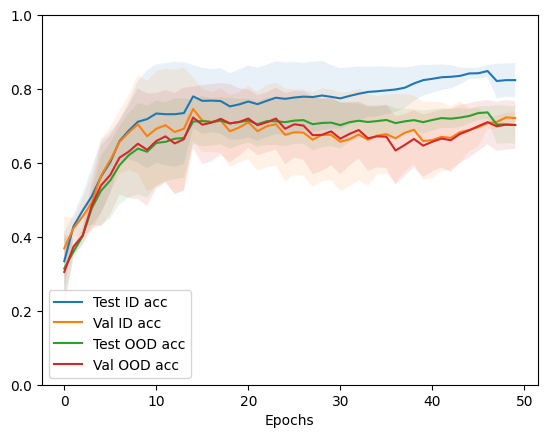

In [61]:
# import matplotlib.pyplot as plt

# plt.plot(test_acc[4:], label="ood test")
# plt.plot(id_test_acc[4:], label="id test")
# plt.plot(train_loss[4:], label="train")
# plt.legend()
# plt.show()

# import matplotlib.pyplot as plt

# plt.plot(test_acc)
# plt.plot(train_loss)
# plt.show

import matplotlib.pyplot as plt 

fig = plt.figure()
# temp_test_acc = train_loss.transpose(1, 0, 2)
# print(temp_test_acc.shape)

acc_means = np.mean(test_acc_arr, axis=0)
acc_stds = np.std(test_acc_arr, axis=0)

val_acc_means = np.mean(val_acc, axis=0)
val_acc_stds = np.std(val_acc, axis=0)

loss_means = np.mean(train_loss, axis=0)
loss_stds = np.std(train_loss, axis=0)

id_acc_means = np.mean(id_test_acc_arr, axis=0)
id_acc_stds = np.std(id_test_acc_arr, axis=0)

val_id_acc_means = np.mean(id_val_acc, axis=0)
val_id_acc_stds = np.std(id_val_acc, axis=0)


plt.ylim(0, 1)

# plt.plot(loss_means[:], label="Train loss")
# plt.fill_between(range(len(loss_means[:])), loss_means[:] - loss_stds[:], loss_means[:] + loss_stds[:], alpha=0.1)


# for i in range(3):
    # plt.plot(test_acc[i,:10], label=f"Subset size: {subset_sizes[i]}")
    
plt.plot(id_acc_means[:], label="Test ID acc")
plt.fill_between(range(len(id_acc_means[:])), id_acc_means[:] - id_acc_stds[:], id_acc_means[:] + id_acc_stds[:], alpha=0.1)

plt.plot(val_id_acc_means[:], label="Val ID acc")
plt.fill_between(range(len(val_id_acc_means[:])), val_id_acc_means[:] - val_id_acc_stds[:], val_id_acc_means[:] + val_id_acc_stds[:], alpha=0.1)


plt.plot(acc_means[:], label="Test OOD acc")
plt.fill_between(range(len(acc_means[:])), acc_means[:] - acc_stds[:], acc_means[:] + acc_stds[:], alpha=0.1)

plt.plot(val_acc_means[:], label="Val OOD acc")
plt.fill_between(range(len(val_acc_means[:])), val_acc_means[:] - val_acc_stds[:], val_acc_means[:] + val_acc_stds[:], alpha=0.1)





plt.legend()
plt.xlabel("Epochs")
# plt.ylabel("Test Accuracy")
plt.show()

In [71]:
from GOOD.data.good_datasets.good_cora import GOODCora
import torch
import dgl 

dur = []
seeds = [10,20,30,40]
epochs = 50
test_acc_arr = np.zeros((len(seeds), epochs))
id_test_acc_arr = np.zeros((len(seeds), epochs))
train_loss = np.zeros((len(seeds), epochs))
id_val_acc = np.zeros((len(seeds), epochs))
val_acc = np.zeros((len(seeds), epochs))

nets = []




for i_s, seed in enumerate(seeds):
    set_seed(seed)    
    net = Net()
    # Add edges between each node and itself to preserve old node representations
    g, data, feats, labels = create_data()
    g.add_edges(g.nodes(), g.nodes())
    features = g.ndata["feats"]
    labels = g.ndata["labels"]
    train_mask = g.ndata["train_mask"]
    test_mask = g.ndata["test_mask"]
    val_mask = g.ndata["val_mask"]
    id_val_mask = g.ndata['id_val_mask']
    id_test_mask = g.ndata['id_test_mask'] 

    optimizer = th.optim.Adam(net.parameters(), lr=1e-2)
    for epoch in range(50):
        if epoch >= 3:
            t0 = time.time()

        net.train()
        logits = net(g, features)
        logp = F.log_softmax(logits, 1)

        loss = F.nll_loss(logp[train_mask], labels[train_mask])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch >= 3:
            dur.append(time.time() - t0)


        acc = evaluate(net, g, features, labels, val_mask)
        id_acc = evaluate(net, g, features, labels, id_val_mask)
        test_acc = evaluate(net, g, features, labels, g.ndata["test_mask"])
        id_test_acc = evaluate(net, g, features, labels,  g.ndata['id_test_mask'])
        print(
            "Epoch {:05d} | Loss {:.4f} | Test OOD Acc {:.4f} | Test ID Acc {:.4f} | Time(s) {:.4f}".format(
                epoch, loss.item(), acc, id_acc, np.mean(dur)
            )
        )
        val_acc[i_s][epoch] = acc
        id_val_acc[i_s][epoch] = id_acc
        test_acc_arr[i_s][epoch] = test_acc
        id_test_acc_arr[i_s][epoch] = id_test_acc
        train_loss[i_s][epoch] = loss.item()
        nets.append(net)

Epoch 00000 | Loss 2.4770 | Test OOD Acc 0.2968 | Test ID Acc 0.3464 | Time(s) nan
Epoch 00001 | Loss 11.5528 | Test OOD Acc 0.3918 | Test ID Acc 0.3980 | Time(s) nan
Epoch 00002 | Loss 7.3862 | Test OOD Acc 0.3816 | Test ID Acc 0.3833 | Time(s) nan
Epoch 00003 | Loss 3.9599 | Test OOD Acc 0.3947 | Test ID Acc 0.4128 | Time(s) 0.1626
Epoch 00004 | Loss 2.3380 | Test OOD Acc 0.4342 | Test ID Acc 0.4816 | Time(s) 0.1627
Epoch 00005 | Loss 1.4658 | Test OOD Acc 0.5175 | Test ID Acc 0.5528 | Time(s) 0.1684
Epoch 00006 | Loss 1.1321 | Test OOD Acc 0.4912 | Test ID Acc 0.5553 | Time(s) 0.1691
Epoch 00007 | Loss 1.2190 | Test OOD Acc 0.4444 | Test ID Acc 0.5381 | Time(s) 0.1683
Epoch 00008 | Loss 1.3457 | Test OOD Acc 0.4196 | Test ID Acc 0.4963 | Time(s) 0.1673
Epoch 00009 | Loss 1.4303 | Test OOD Acc 0.4211 | Test ID Acc 0.4521 | Time(s) 0.1667
Epoch 00010 | Loss 1.4441 | Test OOD Acc 0.4795 | Test ID Acc 0.4644 | Time(s) 0.1662
Epoch 00011 | Loss 1.4180 | Test OOD Acc 0.4956 | Test ID Acc 

Epoch 00046 | Loss 0.3632 | Test OOD Acc 0.8596 | Test ID Acc 0.8600 | Time(s) 0.1724
Epoch 00047 | Loss 0.3582 | Test OOD Acc 0.8582 | Test ID Acc 0.8575 | Time(s) 0.1723
Epoch 00048 | Loss 0.3517 | Test OOD Acc 0.8567 | Test ID Acc 0.8550 | Time(s) 0.1721
Epoch 00049 | Loss 0.3473 | Test OOD Acc 0.8582 | Test ID Acc 0.8550 | Time(s) 0.1723
Epoch 00000 | Loss 2.3020 | Test OOD Acc 0.4211 | Test ID Acc 0.4865 | Time(s) 0.1723
Epoch 00001 | Loss 3.3386 | Test OOD Acc 0.3494 | Test ID Acc 0.4054 | Time(s) 0.1723
Epoch 00002 | Loss 3.8573 | Test OOD Acc 0.4137 | Test ID Acc 0.5135 | Time(s) 0.1723
Epoch 00003 | Loss 2.9690 | Test OOD Acc 0.5629 | Test ID Acc 0.6192 | Time(s) 0.1722
Epoch 00004 | Loss 2.0582 | Test OOD Acc 0.7208 | Test ID Acc 0.7273 | Time(s) 0.1723
Epoch 00005 | Loss 1.4403 | Test OOD Acc 0.7485 | Test ID Acc 0.7592 | Time(s) 0.1722
Epoch 00006 | Loss 1.4786 | Test OOD Acc 0.7515 | Test ID Acc 0.7912 | Time(s) 0.1722
Epoch 00007 | Loss 1.4339 | Test OOD Acc 0.7749 | Test

Epoch 00042 | Loss 0.4187 | Test OOD Acc 0.8173 | Test ID Acc 0.8378 | Time(s) 0.1731
Epoch 00043 | Loss 0.4111 | Test OOD Acc 0.8216 | Test ID Acc 0.8354 | Time(s) 0.1730
Epoch 00044 | Loss 0.3977 | Test OOD Acc 0.8260 | Test ID Acc 0.8428 | Time(s) 0.1730
Epoch 00045 | Loss 0.3875 | Test OOD Acc 0.8275 | Test ID Acc 0.8428 | Time(s) 0.1730
Epoch 00046 | Loss 0.3738 | Test OOD Acc 0.8304 | Test ID Acc 0.8428 | Time(s) 0.1730
Epoch 00047 | Loss 0.3627 | Test OOD Acc 0.8392 | Test ID Acc 0.8477 | Time(s) 0.1729
Epoch 00048 | Loss 0.3518 | Test OOD Acc 0.8348 | Test ID Acc 0.8403 | Time(s) 0.1728
Epoch 00049 | Loss 0.3442 | Test OOD Acc 0.8392 | Test ID Acc 0.8403 | Time(s) 0.1728


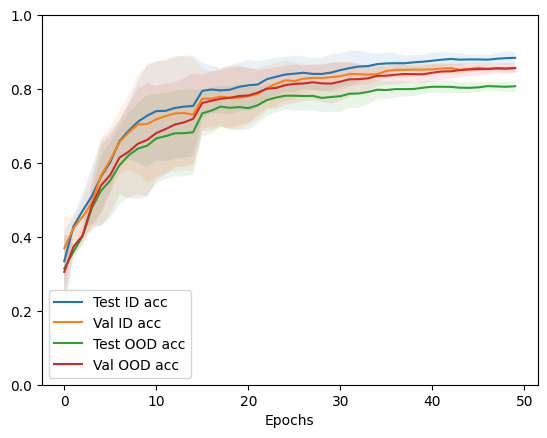

In [72]:
# import matplotlib.pyplot as plt

# plt.plot(test_acc[4:], label="ood test")
# plt.plot(id_test_acc[4:], label="id test")
# plt.plot(train_loss[4:], label="train")
# plt.legend()
# plt.show()

# import matplotlib.pyplot as plt

# plt.plot(test_acc)
# plt.plot(train_loss)
# plt.show

import matplotlib.pyplot as plt 

fig = plt.figure()
# temp_test_acc = train_loss.transpose(1, 0, 2)
# print(temp_test_acc.shape)

acc_means = np.mean(test_acc_arr, axis=0)
acc_stds = np.std(test_acc_arr, axis=0)

val_acc_means = np.mean(val_acc, axis=0)
val_acc_stds = np.std(val_acc, axis=0)

loss_means = np.mean(train_loss, axis=0)
loss_stds = np.std(train_loss, axis=0)

id_acc_means = np.mean(id_test_acc_arr, axis=0)
id_acc_stds = np.std(id_test_acc_arr, axis=0)

val_id_acc_means = np.mean(id_val_acc, axis=0)
val_id_acc_stds = np.std(id_val_acc, axis=0)


plt.ylim(0, 1)

# plt.plot(loss_means[:], label="Train loss")
# plt.fill_between(range(len(loss_means[:])), loss_means[:] - loss_stds[:], loss_means[:] + loss_stds[:], alpha=0.1)


# for i in range(3):
    # plt.plot(test_acc[i,:10], label=f"Subset size: {subset_sizes[i]}")
    
plt.plot(id_acc_means[:], label="Test ID acc")
plt.fill_between(range(len(id_acc_means[:])), id_acc_means[:] - id_acc_stds[:], id_acc_means[:] + id_acc_stds[:], alpha=0.1)

plt.plot(val_id_acc_means[:], label="Val ID acc")
plt.fill_between(range(len(val_id_acc_means[:])), val_id_acc_means[:] - val_id_acc_stds[:], val_id_acc_means[:] + val_id_acc_stds[:], alpha=0.1)


plt.plot(acc_means[:], label="Test OOD acc")
plt.fill_between(range(len(acc_means[:])), acc_means[:] - acc_stds[:], acc_means[:] + acc_stds[:], alpha=0.1)

plt.plot(val_acc_means[:], label="Val OOD acc")
plt.fill_between(range(len(val_acc_means[:])), val_acc_means[:] - val_acc_stds[:], val_acc_means[:] + val_acc_stds[:], alpha=0.1)





plt.legend()
plt.xlabel("Epochs")
# plt.ylabel("Test Accuracy")
plt.show()

In [73]:
acc = evaluate(net, g, features, labels, g.ndata['test_mask'])
id_acc = evaluate(net, g, features, labels, g.ndata['id_test_mask'])

print(f"OOD ACC: {np.mean(np.max(test_acc_arr, axis=0))} (+/-{np.std(np.max(test_acc_arr, axis=0))})")
print(f"ID ACC: {np.mean(np.max(id_test_acc_arr, axis=0))} (+/-{np.std(np.max(id_test_acc_arr, axis=0))})")

OOD ACC: 0.7832027257240203 (+/-0.1061670872760031)
ID ACC: 0.8570120481927711 (+/-0.11274081562682381)


In [63]:
dur = []
seeds = [30,40]
epochs = 50
test_acc_arr = np.zeros((len(seeds), epochs))
id_test_acc_arr = np.zeros((len(seeds), epochs))
train_loss = np.zeros((len(seeds), epochs))
id_val_acc = np.zeros((len(seeds), epochs))
val_acc = np.zeros((len(seeds), epochs))

nets = []




for i_s, seed in enumerate(seeds):
    set_seed(seed)    
    net = Net()
    # Add edges between each node and itself to preserve old node representations
    g, data, feats, labels = create_data()
    g.add_edges(g.nodes(), g.nodes())
    features = g.ndata["feats"]
    labels = g.ndata["labels"]
    train_mask = g.ndata["train_mask"]
    test_mask = g.ndata["test_mask"]
    val_mask = g.ndata["val_mask"]
    id_val_mask = g.ndata['id_val_mask']
    id_test_mask = g.ndata['id_test_mask'] 

    optimizer = th.optim.Adam(net.parameters(), lr=1e-2)
    
    E = torch.zeros(train_mask.shape[0])
    k = 250
    

    for epoch in range(50):
        if epoch >= 3:
            t0 = time.time()

        net.train()
        logits = net(g, features)
        logp = F.log_softmax(logits, 1)

        correct = torch.argmax(logp, dim=1) == labels
        correct[~(train_mask+val_mask)] = False
        E += correct

        loss = F.nll_loss(logp[train_mask], labels[train_mask])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch >= 3:
            dur.append(time.time() - t0)


        if epoch % 3 == 0 and epoch != 0 and epoch < 45 and epoch > 5:
            true_idx = np.argwhere(train_mask + val_mask + id_val_mask)[0]
            remove_idx = np.random.choice(true_idx, size=k, replace=False)

            g = dgl.remove_nodes(g, remove_idx)
            features = g.ndata["feats"]
            labels = g.ndata["labels"]
            train_mask = g.ndata["train_mask"]
            val_mask = g.ndata["val_mask"]
            id_val_mask = g.ndata["id_val_mask"]
            E = torch.zeros(train_mask.shape[0])
            k = int(0.9*k)
            print(sum(train_mask), sum(val_mask), sum(id_val_mask))

        acc = evaluate(net, g, features, labels, val_mask)
        id_acc = evaluate(net, g, features, labels, id_val_mask)
        test_acc = evaluate(net, g, features, labels, g.ndata["test_mask"])
        id_test_acc = evaluate(net, g, features, labels,  g.ndata['id_test_mask'])
        print(
            "Epoch {:05d} | Loss {:.4f} | Test OOD Acc {:.4f} | Test ID Acc {:.4f} | Time(s) {:.4f}".format(
                epoch, loss.item(), acc, id_acc, np.mean(dur)
            )
        )
        val_acc[i_s][epoch] = acc
        id_val_acc[i_s][epoch] = id_acc
        test_acc_arr[i_s][epoch] = test_acc
        id_test_acc_arr[i_s][epoch] = id_test_acc
        train_loss[i_s][epoch] = loss.item()
        nets.append(net)

Epoch 00000 | Loss 2.3020 | Test OOD Acc 0.4211 | Test ID Acc 0.4865 | Time(s) nan
Epoch 00001 | Loss 3.3386 | Test OOD Acc 0.3494 | Test ID Acc 0.4054 | Time(s) nan
Epoch 00002 | Loss 3.8573 | Test OOD Acc 0.4137 | Test ID Acc 0.5135 | Time(s) nan
Epoch 00003 | Loss 2.9690 | Test OOD Acc 0.5629 | Test ID Acc 0.6192 | Time(s) 0.1787
Epoch 00004 | Loss 2.0582 | Test OOD Acc 0.7208 | Test ID Acc 0.7273 | Time(s) 0.1819
Epoch 00005 | Loss 1.4403 | Test OOD Acc 0.7485 | Test ID Acc 0.7592 | Time(s) 0.1862
tensor(1624) tensor(625) tensor(378)
Epoch 00006 | Loss 1.4786 | Test OOD Acc 0.7424 | Test ID Acc 0.7857 | Time(s) 0.1839
Epoch 00007 | Loss 1.3892 | Test OOD Acc 0.7632 | Test ID Acc 0.7937 | Time(s) 0.1837
Epoch 00008 | Loss 1.1438 | Test OOD Acc 0.8032 | Test ID Acc 0.8201 | Time(s) 0.1758
tensor(1488) tensor(571) tensor(343)
Epoch 00009 | Loss 0.8818 | Test OOD Acc 0.8056 | Test ID Acc 0.8571 | Time(s) 0.1740
Epoch 00010 | Loss 0.7786 | Test OOD Acc 0.8004 | Test ID Acc 0.8513 | Time

Epoch 00036 | Loss 0.6328 | Test OOD Acc 0.7402 | Test ID Acc 0.7674 | Time(s) 0.1202
Epoch 00037 | Loss 0.6179 | Test OOD Acc 0.7438 | Test ID Acc 0.7674 | Time(s) 0.1198
Epoch 00038 | Loss 0.5994 | Test OOD Acc 0.7367 | Test ID Acc 0.7616 | Time(s) 0.1198
tensor(678) tensor(260) tensor(169)
Epoch 00039 | Loss 0.5819 | Test OOD Acc 0.7346 | Test ID Acc 0.7574 | Time(s) 0.1192
Epoch 00040 | Loss 0.5743 | Test OOD Acc 0.7423 | Test ID Acc 0.7515 | Time(s) 0.1187
Epoch 00041 | Loss 0.5581 | Test OOD Acc 0.7423 | Test ID Acc 0.7515 | Time(s) 0.1183
tensor(640) tensor(242) tensor(158)
Epoch 00042 | Loss 0.5422 | Test OOD Acc 0.7521 | Test ID Acc 0.7532 | Time(s) 0.1181
Epoch 00043 | Loss 0.5406 | Test OOD Acc 0.7603 | Test ID Acc 0.7532 | Time(s) 0.1177
Epoch 00044 | Loss 0.5259 | Test OOD Acc 0.7603 | Test ID Acc 0.7848 | Time(s) 0.1172
Epoch 00045 | Loss 0.5120 | Test OOD Acc 0.7562 | Test ID Acc 0.7848 | Time(s) 0.1168
Epoch 00046 | Loss 0.4988 | Test OOD Acc 0.7686 | Test ID Acc 0.7848

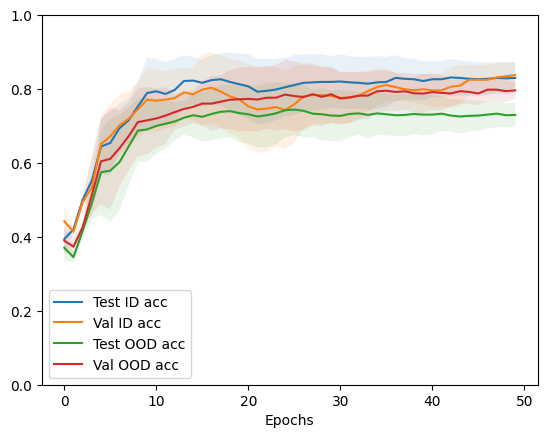

In [64]:
# import matplotlib.pyplot as plt

# plt.plot(test_acc[4:], label="ood test")
# plt.plot(id_test_acc[4:], label="id test")
# plt.plot(train_loss[4:], label="train")
# plt.legend()
# plt.show()

# import matplotlib.pyplot as plt

# plt.plot(test_acc)
# plt.plot(train_loss)
# plt.show

import matplotlib.pyplot as plt 

fig = plt.figure()
# temp_test_acc = train_loss.transpose(1, 0, 2)
# print(temp_test_acc.shape)

acc_means = np.mean(test_acc_arr, axis=0)
acc_stds = np.std(test_acc_arr, axis=0)

val_acc_means = np.mean(val_acc, axis=0)
val_acc_stds = np.std(val_acc, axis=0)

loss_means = np.mean(train_loss, axis=0)
loss_stds = np.std(train_loss, axis=0)

id_acc_means = np.mean(id_test_acc_arr, axis=0)
id_acc_stds = np.std(id_test_acc_arr, axis=0)

val_id_acc_means = np.mean(id_val_acc, axis=0)
val_id_acc_stds = np.std(id_val_acc, axis=0)


plt.ylim(0, 1)

# plt.plot(loss_means[:], label="Train loss")
# plt.fill_between(range(len(loss_means[:])), loss_means[:] - loss_stds[:], loss_means[:] + loss_stds[:], alpha=0.1)


# for i in range(3):
    # plt.plot(test_acc[i,:10], label=f"Subset size: {subset_sizes[i]}")
    
plt.plot(id_acc_means[:], label="Test ID acc")
plt.fill_between(range(len(id_acc_means[:])), id_acc_means[:] - id_acc_stds[:], id_acc_means[:] + id_acc_stds[:], alpha=0.1)

plt.plot(val_id_acc_means[:], label="Val ID acc")
plt.fill_between(range(len(val_id_acc_means[:])), val_id_acc_means[:] - val_id_acc_stds[:], val_id_acc_means[:] + val_id_acc_stds[:], alpha=0.1)


plt.plot(acc_means[:], label="Test OOD acc")
plt.fill_between(range(len(acc_means[:])), acc_means[:] - acc_stds[:], acc_means[:] + acc_stds[:], alpha=0.1)

plt.plot(val_acc_means[:], label="Val OOD acc")
plt.fill_between(range(len(val_acc_means[:])), val_acc_means[:] - val_acc_stds[:], val_acc_means[:] + val_acc_stds[:], alpha=0.1)





plt.legend()
plt.xlabel("Epochs")
# plt.ylabel("Test Accuracy")
plt.show()

In [65]:
acc = evaluate(net, g, features, labels, g.ndata['test_mask'])
id_acc = evaluate(net, g, features, labels, g.ndata['id_test_mask'])


print(f"OOD ACC: {np.mean(np.max(test_acc_arr, axis=0))} (+/-{np.std(np.max(test_acc_arr, axis=0))})")
print(f"ID ACC: {np.mean(np.max(id_test_acc_arr, axis=0))} (+/-{np.std(np.max(id_test_acc_arr, axis=0))})")

OOD ACC: 0.7557751277683135 (+/-0.09980798760434349)
ID ACC: 0.8413012048192772 (+/-0.1102625010234644)
